# Causal sales analytics: a deep-dive on discrete choice modeling

**Authored by:** Benjamin Vincent

![](cover.png)

In [1]:
import warnings

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from scipy.special import expit
import matplotlib.pyplot as plt
import pymc as pm
from matplotlib.patches import Ellipse
import graphviz as gr
from IPython.display import Image

In [2]:
plt.rcParams["figure.figsize"] = [10, 6]
%config InlineBackend.figure_format = "retina"
plt.rcParams.update({"figure.constrained_layout.use": True})

In [3]:
seed = sum(map(ord, "customer choice modeling"))
rng = np.random.default_rng(seed)

_**Executive Summary:** TO BE WRITTEN BY BEN WHEN POST IS COMPLETE_

## Introduction

In our first post on [causal sales analytics](https://www.pymc-labs.com/blog-posts/causal-sales-analytics-are-my-sales-incremental-or-cannibalistic/) we outlined the problem of estimating the degree to which a new product's sales is incremental (i.e. sales taken from competitors) or cannibalistic (i.e. sales that would have gone to your existing products). We also outlined a multivariate interrupted time series approach which could be used to address this problem. However, we saw that while it was elegant and potentially has use in simple markets, it was not going to help us in a complex consumer goods market.

In this post we will sketch the solution that we built for Colgate-Palmolive. This solution is based on the [discrete choice modeling](https://en.wikipedia.org/wiki/Discrete_choice) framework, which is a class of model that is widely used in marketing and economics to model consumer choice. We will show how to code up _a simple version_ of this model in PyMC to convey the power of the general approach.

However, we will also highlight that a simple discrete choice model is not enough to solve the particular problem we were faced with. We will highlight these problems and _partially_ outline the challenges and solutions (in maths) that we developed. We of course need to keep some [secrete sauce](https://en.wikipedia.org/wiki/Secret_ingredient) for our clients 😀

The solution we provided represented a significant advance in the state of the art in causal sales analytics, beyond what is available in any published discrete choice modeling literature. We are excited to share this with the community, to show what PyMC Labs is capable of.

## The causal sales analytics problem

For our particular problem, it is important to remember that our client was a manufacturer of consumer goods and not a retailer. This means that they do not have access to customer-level sales data. Instead, they have access to _aggregated_ sales data at the product level for both their (and competitor) products.

This access to highly aggregated sales data was one of the key challenges in this project. Not being able to directly observe individual customer choices means that we have to infer the underlying consumer choice model from the aggregate sales data. This is a challenging problem.

Our goal was to produce a causal sales analytics model (in a private well-documented python package) that could be used by our client to estimate the degree of incrementality or cannibalization of new product introductions. This would allow them to make better decisions about which products to launch and how to market them. As we identified in our first post, having a causal approach to this problem is key because we need to make counterfactual inferences. More specifically, we need to estimate the counterfactual sales what all products would have been if the new product had not been introduced. The difference between the actual and the counterfactal outcome will give us an approximation to the causal impact of the new product introduction.

The data had an [unbalanced panel](https://en.wikipedia.org/wiki/Panel_data) structure -- there were timeseries for many products. Each row corresponded to a given date and product. It was unbalanced because not all products were distributed for sale at all times.

The outcome variable in our dataset (one of the columns) was **sales volume** aggregated at the product level. No customer-level or store-level data was available.

The other columns contain the predictor variables, which include: 

* **Price**: the price of the product
* **ACV**: All Commodity Volume is definitely not a perfect metric, but it approximates the distribution of the product in the market. This was an important predictor variable in our model - a product may be fantastic, but if it is not on the shelf, it will not sell.
* **Date**: The data were available at weekly resolution
* **Brand**: the brand of the product
* **Manufacturer**: the manufacturer of the product
* **SKU**: the product ID in the form of a [Stock Keeping Unit](https://en.wikipedia.org/wiki/Stock_keeping_unit)

So let's put this altogether into a causal sales analytics model. Below we shows one possible causal DAG for the problem. We can describe this as:
* Price, ACV, base product appeal and consumer price elasticity all causally influence the appeal (i.e. utility) of each product.
* The utilities of each product causally determines the latent market share.
* The latent market share and the total sales demand causally determines the sales volume of each product.

Grey shaded nodes represent observed data, white nodes represent unobserved variables, and the arrows represent causal relationships.

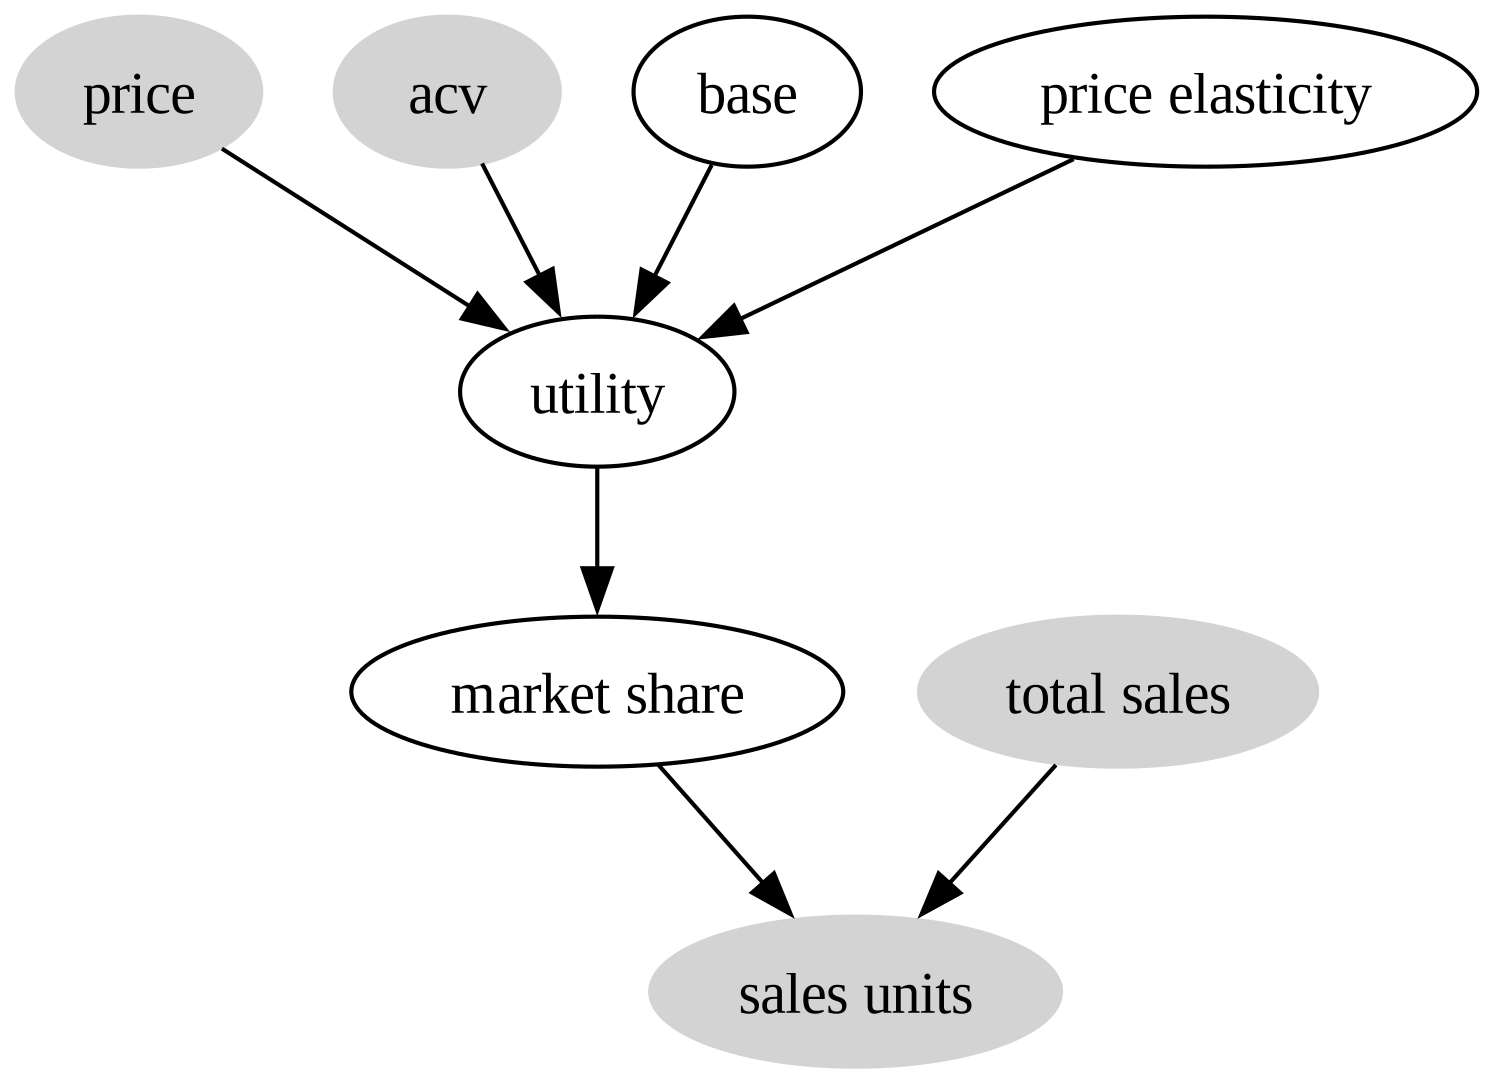

In [4]:
g = gr.Digraph(format="png", graph_attr={"dpi": "300"})
g.node(name="price", label="price", color="lightgrey", style="filled")
g.node(name="acv", label="acv", color="lightgrey", style="filled")
g.node(name="base", label="base")
g.node(name="utility", label="utility")
g.node(name="price elasticity", label="price elasticity")
g.node(name="total sales", label="total sales", color="lightgrey", style="filled")
g.node(name="sales units", label="sales units", color="lightgrey", style="filled")
g.node(name="market share", label="market share")

g.edge(tail_name="price", head_name="utility")
g.edge(tail_name="acv", head_name="utility")
g.edge(tail_name="base", head_name="utility")
g.edge(tail_name="price elasticity", head_name="utility")

g.edge(tail_name="utility", head_name="market share")
g.edge(tail_name="market share", head_name="sales units")
g.edge(tail_name="total sales", head_name="sales units")

g.render(filename="_dag")
Image(filename="_dag.png")

## A primer to discrete choice modeling

In this section we will introduce the basic approach by outlining a simple discrete choice model. This model is a _vastly_ simplified version what we built, but it will be sufficient to convey the general idea. We will highlight it's limitations and in a later section we'll outline our novel solutions - both mathematical and computational.

The core of the approach can be summarized as:

> Individuals consider a menu of options (i.e. products) and choose that which maximises their utility. Aggregate market-level behaviours follow from many individual actions.

### Sales as a discrete choice problem

Our outcome variable (sale counts of items) as the outcome of rolling $n$ biased dice (i.e. $n$ total sales), we can use the [Multinomial](https://en.wikipedia.org/wiki/Multinomial_distribution) likelihood function:

$$
\mathbf{k} \sim \text{Multinomial}(\mathbf{p}, n)
$$

where $\mathbf{k}$ is a vector with each value reflecting the number of times the corresponding product was purchased, $\mathbf{p}$ is a vector with each value reflecting the probability each product is selected, and $n$ is the total number of purchases.

One may conceptualize $\mathbf{p}$ as summarizing customer preferences. So the question is, where do these preferences come from?

### Utilities 

Discrete choice models assume that consumers' choices are guided by [**utility**](https://en.wikipedia.org/wiki/Utility). Utility is a latent construct which, loosely speaking, captures how much an individual likes a particular option. The higher the utility of an option, the more likely the individual is to select the option. The lower the utility, the less likely the individual is to select the option. Utility must be inferred because it is not directly observable; we can only infer utilities that are consistent with a set of observed choices. Nevertheless, the construct of utility has a long history in economics and can be a _useful_ way to think about how people make choices.

How does this work? Discrete choice models assume that choice probabilities ($\mathbf{p}$ in the equation above) are a function of utilities. More specifically, we use the softmax function to convert utilities $(- \infty, + \infty)$ into probabilities $(0, 1)$:

$$
\mathbf{p} = \operatorname{softmax}(\mathbf{u}) = \frac{\exp(\mathbf{u})}{\sum_{i=1}^P \exp(u_i)}
$$

where $P$ is the total number of products available.

So, from the perspective of [generalized linear modeling](https://en.wikipedia.org/wiki/Generalized_linear_model), the softmax is an [inverse link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function).

### Where do utilities come from?

Simply put, we can use linear regression to create a mapping from product attributes to utilities. If we consider a single product, $i$, then we could imagine that the utility of that product is a linear function of its attributes:

$$
u_i = \beta_0 + \Sigma_{j=1}^J [ \beta_j x_{ij}  ] + \epsilon_i
$$

where:

* $u_i$ is the utility of product $i$.
* $j$ is the index of the $j^{\th}$ attribute of product $i$.
* $\beta_0$ is the intercept. We can interpret this as the baseline utility of product $i$ when all of its attributes are zero.
* $\beta_j$ is the regression coefficient for the $j^{\th}$ attribute, $x_j$. We can interpret this as the change in utility of product $i$ for a one unit change in attribute $x_j$.
* $\epsilon_i$ is the error term. This is a random variable which captures the fact that we cannot perfectly predict the utility of a product from its attributes.

This precise approach outlined here will end up not being sufficiently flexible for the purpose of the current project. However, it is a good starting point for developing an understanding of discrete choice models.

!!! note "Product attributes are our predictor variables"
    Product attributes are the things which we think might influence the utility of a product such as price, brand, flavor, pack size, etc. For example, we might expect that the higher the price of a product, the lower the utility of that product, and therefore would expect price to be associated with a negative regression coefficient.

!!! note "Errors, $\epsilon_i$"
    Different assumptions about the distribution of $\epsilon_i$ imply different choice functions. For example, if we assume $\epsilon_i \sim \operatorname{Logistic}(1)$ then this leads to the logit/softmax approach. Alternatively, if we assumed $\epsilon_i$ were normally distributed then it would lead to the probit approach.

## Simple discrete choice model in PyMC

Ok, we've done a quick intro to discrete choice models, to let's put all that together into code. Remember, this is a small toy example we are using to get acquainted with the general approach. Let's first take a look at a mathematical representation of the model:

$$
\begin{aligned}
\vec{\beta}_0 &\sim \text{Normal}(0, 1) \\
\gamma_i &\sim \text{Normal}(-0.8, 0.1) \\
u_{i,t} &= \big[ \beta_{0,i} + \log(acv_{i,t}) \big] \cdot price_{i,t}^{\gamma_i}\\
        &=  \beta_{0,i} + \log(acv_{i,t}) + \gamma_i \cdot \log(price_{i,t})\\
p_{i,t} &= \text{softmax}(u_{i,t})\\
k_{i,t} &\sim \text{Multinomial}(p_{i,t}, n_t)
\end{aligned}
$$

base_utility + np.log(acv) + γ * log(price)

We have observed data:
* $acv_{i,t}$: the all commodity volume of product $i$ at time $t$
* $price_{i,t}$: the price of product $i$ at time $t$
* $n_t$: the total number of sales at time $t$

where $i$ is the index of the product and $t$ is the index of the time period.

The parameters are:
* $base_i$: the base utility for a given item $i$ when all other predictors are zero. The higher this value, the more likely it is to be purchased, ignoring all other factors.
* $\gamma_i$: the price elasticity for item $i$. Although bear in mind that this represents the % change _in utility_ for a 1% change in price. This is not the same as the % change _in sales_ for a 1% change in price.

The softmax function is computed over all products at time $t$.

Bear in mind that we've modified the equation defining utility. We've added a multiplicative effect of price upon utility which allows us to include a true price elasticity parameter, $\gamma_i$.

The $\log(acv_{i,t})$ term is how we dealt with products that were not on any shelves. If the acv is zero, then the log will be negative infinity. This in turn makes the utility negative infinity and the probability of being purchased is zero. This is a simple way to deal with the fact that products that are not on the shelf do not sell.

Note that, for this model we assume that total sales are exogenous - that is they are provided to us as observations which are not part of the data generating process of this model. In our actual client work we modeled the data generating process of total sales, but we will not cover that here.

### Loading simulated data

We'll load some simulated data to illustrate this model.

In [12]:
data = pd.read_csv("data.csv", parse_dates=["date"])
data

,date,manufacturer,segment,brand,acv,price,sales_units
0,2023-03-24,GlaxoSniffKline,Adult,Parobontax,0.988611,12.771459,2504
1,2023-03-24,GlaxoSniffKline,Adult,Sensofyne Quick Relief,0.000000,17.610908,0
2,2023-03-24,Precter & Jangle,Adult,Cwest Pro-Heels,0.872648,11.857831,3051
3,2023-03-24,Precter & Jangle,Adult,Cwest Gum Detoxo,0.000000,18.357398,0
4,2023-03-24,Smolgate-Jalmolive,Adult,Smolgate Optic Wite,0.849262,10.846502,747
...,...,...,...,...,...,...,...
715,2024-05-10,GlaxoSniffKline,Kids,Ninions,0.905953,17.014801,2627
716,2024-05-10,Precter & Jangle,Kids,Cwest HyperMan,0.000000,10.930132,0
717,2024-05-10,Precter & Jangle,Kids,Cwest Happy baby,0.964371,11.211608,1783
718,2024-05-10,Smolgate-Jalmolive,Kids,Smolgate Total,0.000000,17.591442,0


In [13]:
product_df = data[["manufacturer", "segment", "brand"]].drop_duplicates()
product_df

,manufacturer,segment,brand
0,GlaxoSniffKline,Adult,Parobontax
1,GlaxoSniffKline,Adult,Sensofyne Quick Relief
2,Precter & Jangle,Adult,Cwest Pro-Heels
3,Precter & Jangle,Adult,Cwest Gum Detoxo
4,Smolgate-Jalmolive,Adult,Smolgate Optic Wite
5,Smolgate-Jalmolive,Adult,Smolgate Sensotouch
6,GlaxoSniffKline,Kids,White Star
7,GlaxoSniffKline,Kids,Ninions
8,Precter & Jangle,Kids,Cwest HyperMan
9,Precter & Jangle,Kids,Cwest Happy baby


In [15]:
wide_data = pd.pivot_table(data, index="date", columns=["brand"], values=["acv", "price", "sales_units"], sort=False)
date = wide_data.index
acv = wide_data["acv"].values
price = wide_data["price"].values
sales_units = wide_data["sales_units"].values
market_share = sales_units / np.sum(sales_units, axis=1, keepdims=True)

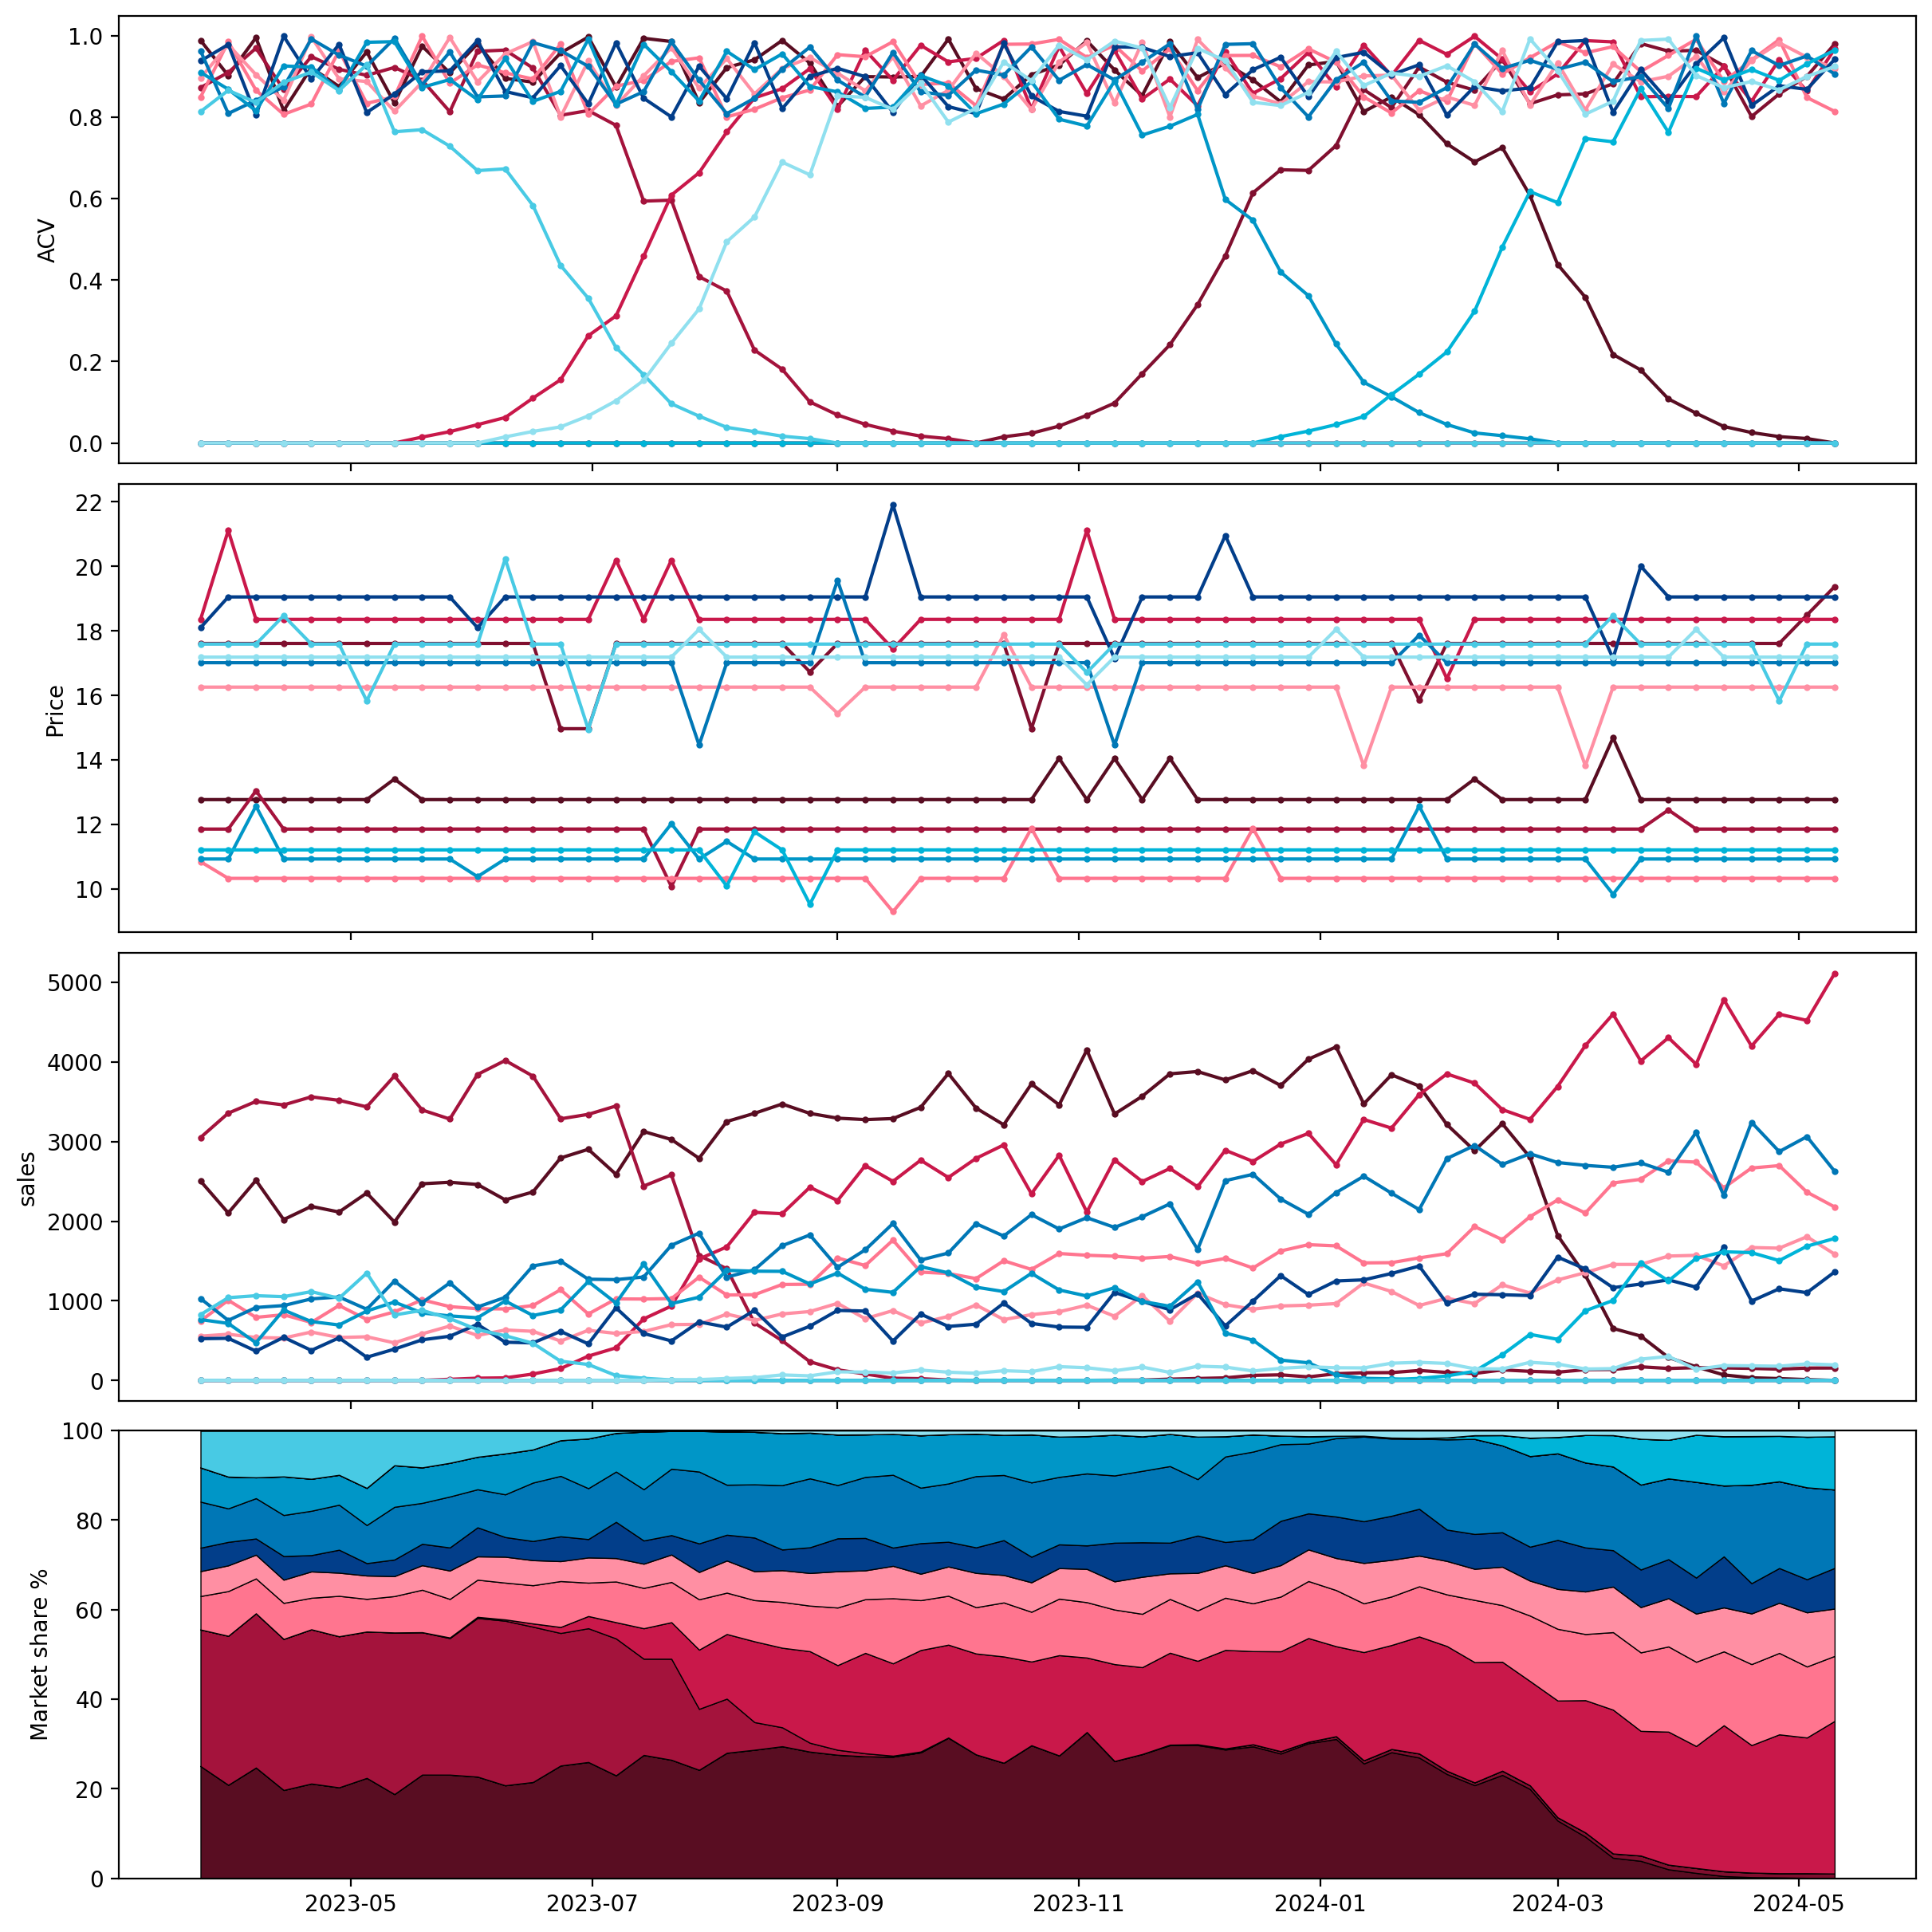

In [16]:
colors = [
    '#590d22', '#800f2f', '#a4133c', '#c9184a', '#ff758f', '#ff8fa3',
    '#023e8a', '#0077b6', '#0096c7', '#00b4d8', '#48cae4', '#90e0ef',
]

_, ax = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

for i, color in enumerate(colors):
    ax[0].plot(date, acv[..., i], color=color, marker="o", markersize=2)
    ax[1].plot(date, price[..., i], color=color, marker="o", markersize=2)
    ax[2].plot(date, sales_units[..., i], color=color, marker="o", markersize=2)

ax[3].stackplot(
    date, 100 * market_share.T,
    colors=colors, ec="k", lw=0.5
)

ax[0].set(ylabel="ACV")
ax[1].set(ylabel="Price")
#ax[1].set_ylim(bottom=0)
ax[2].set(ylabel="sales");
ax[3].set(ylabel="Market share %", ylim=(0, 100));

The top plot shows that there are different 'classes's of products. Some are persistently distributed all through the time period we are looking at. Others are introduced, with distribution starting at zero and ramping up. Finally, some are discontinued, with distribution ramping down to zero. The second plot shows the price of the products, and the last two the total sales and market share of each product.

Products in blue belong to the first segment and products in red to the second.

Now we'll build the model in PyMC and fit this data.

In [30]:
coords = dict(
    brand=product_df["brand"].values,
    date=date,
)

with pm.Model(coords=coords) as simple_logit_model:
    # Data
    acv_data = pm.Data("acv", acv, dims=["date", "brand"])
    total_sales_data = pm.Data("total_sales", sales_units.sum(-1), dims=["date"])
    log_price_data = pm.Data("log_price", np.log(price), dims=["date", "brand"])

    # Priors
    base_utility = pm.ZeroSumNormal("base_utility", dims="brand")
    γ = pm.Normal("γ", mu=-0.8, sigma=0.2, dims="brand")    

    # Model
    # Rather than computing: (base_utility + np.log(acv)) * price**γ
    # We compute: base_utility + np.log(acv) + γ * log(price)
    # This offers improved numerical stability and keeps the model 'linear in the parameters'
    utility = pm.Deterministic(
        "utility",
        base_utility + pm.math.log(acv_data) + γ * log_price_data,
        dims=["date", "brand"],
    )

    market_share = pm.Deterministic(
        "market_share", pm.math.softmax(utility, axis=-1), dims=["date", "brand"]
    )

    # Likelihood
    pm.Multinomial("sales_units", n=total_sales_data, p=market_share, dims=["date", "brand"], observed=sales_units)

It always helps to understand a model by looking at its graphviz representation. We can see the direct similarity between this PyMC graphviz representation and our causal DAG above.

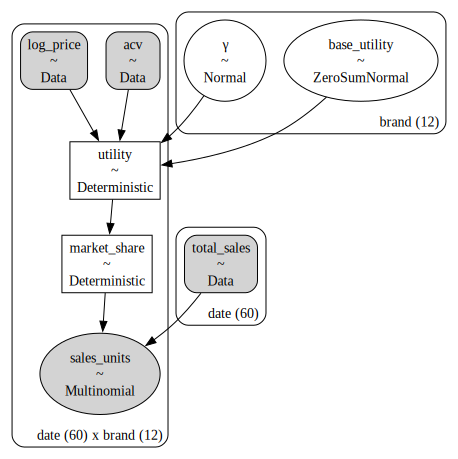

In [31]:
simple_logit_model.to_graphviz()

In [34]:
with simple_logit_model:
    idata_simple_logit_model = pm.sample(random_seed=rng)
    pm.sample_posterior_predictive(idata_simple_logit_model, random_seed=rng, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [base_utility, γ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 295 seconds.
Sampling: [sales_units]


Output()

Let's check how well the model is able to account for the observed data. We'll do this by comparing the observed sales data (points) with the model's posterior predicted sales (lines represent posterior mean and shaded regions represent 94% HDI's).

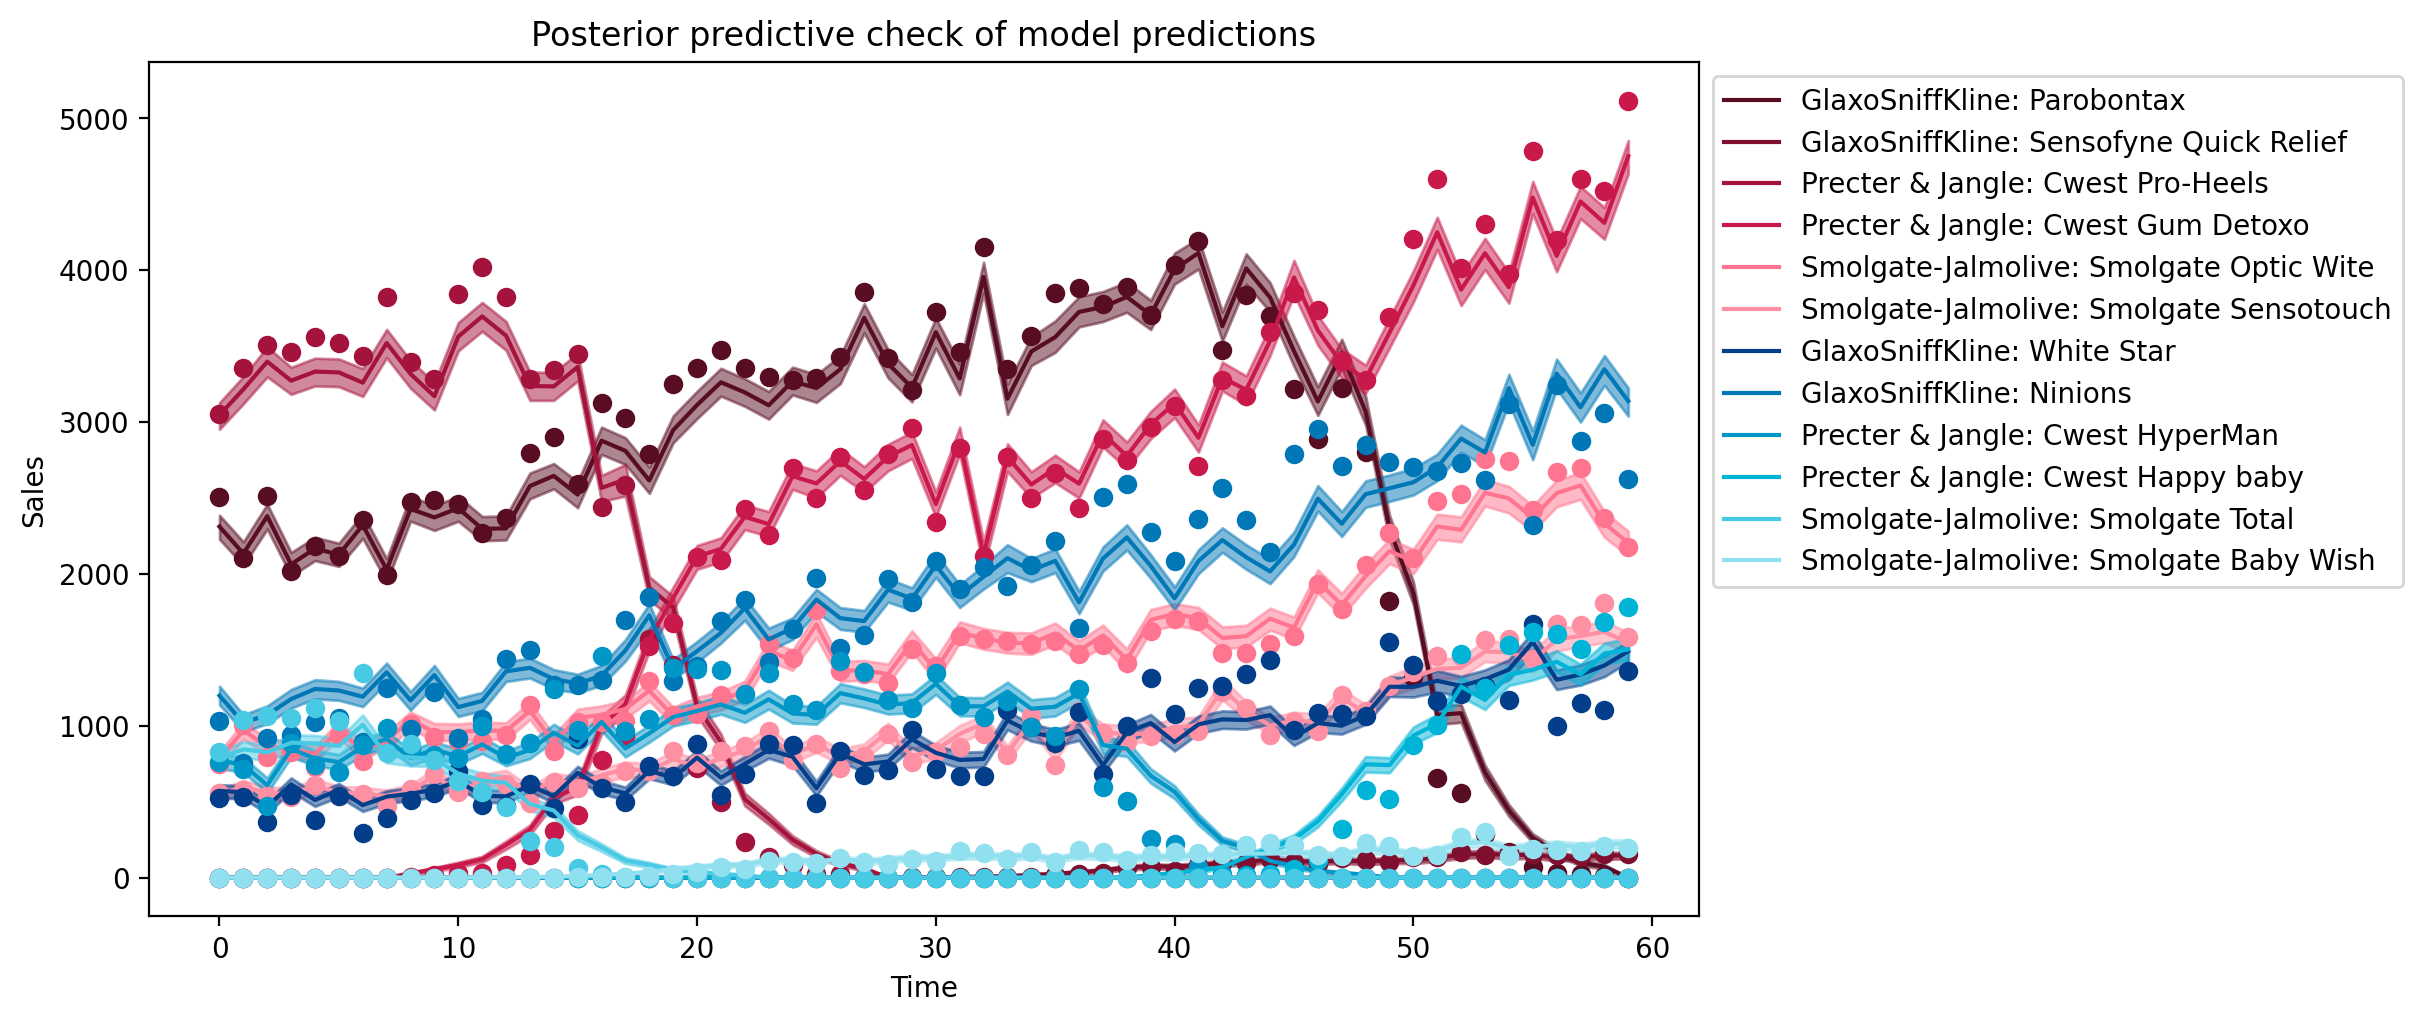

In [49]:
fig, ax = plt.subplots(figsize=(12, 5))

x = range(acv.shape[0])

# plot posterior predictive
for i, brand in enumerate(idata_simple_logit_model.constant_data.brand):
    az.plot_hdi(
        x,
        idata_simple_logit_model.posterior_predictive["sales_units"].sel({"brand": brand}),
        color=colors[i],
        smooth=False,
        ax=ax,
    )
    ax.plot(
        x,
        idata_simple_logit_model.posterior_predictive["sales_units"]
        .sel({"brand": brand})
        .mean(dim=["chain", "draw"]),
        color=colors[i],
        label=f"{product_df['manufacturer'][i]}: {product_df['brand'][i]}",
    )

    # plot data
    ax.plot(x, sales_units[:, i], "o", color=colors[i])

ax.legend(loc="upper left", bbox_to_anchor=[1, 1])
ax.set(
    title="Posterior predictive check of model predictions",
    xlabel="Time",
    ylabel="Sales",
);

The model is doing an okay job at accounting for the general trends observed data, although the posterior distributions for the parameters often miss the true values.

We can probe the model further and examine the parameter estimates. Again, because we simulated the data and know the true parameter values, we can compare the two to see how well this is working.

In [50]:
γ_true = az.extract(true.prior, var_names=["γ"]).to_numpy().ravel()
base_utility_true = (
    az.extract(true.prior, var_names=["base_utility"]).to_numpy().ravel()
)

NameError: name 'true' is not defined

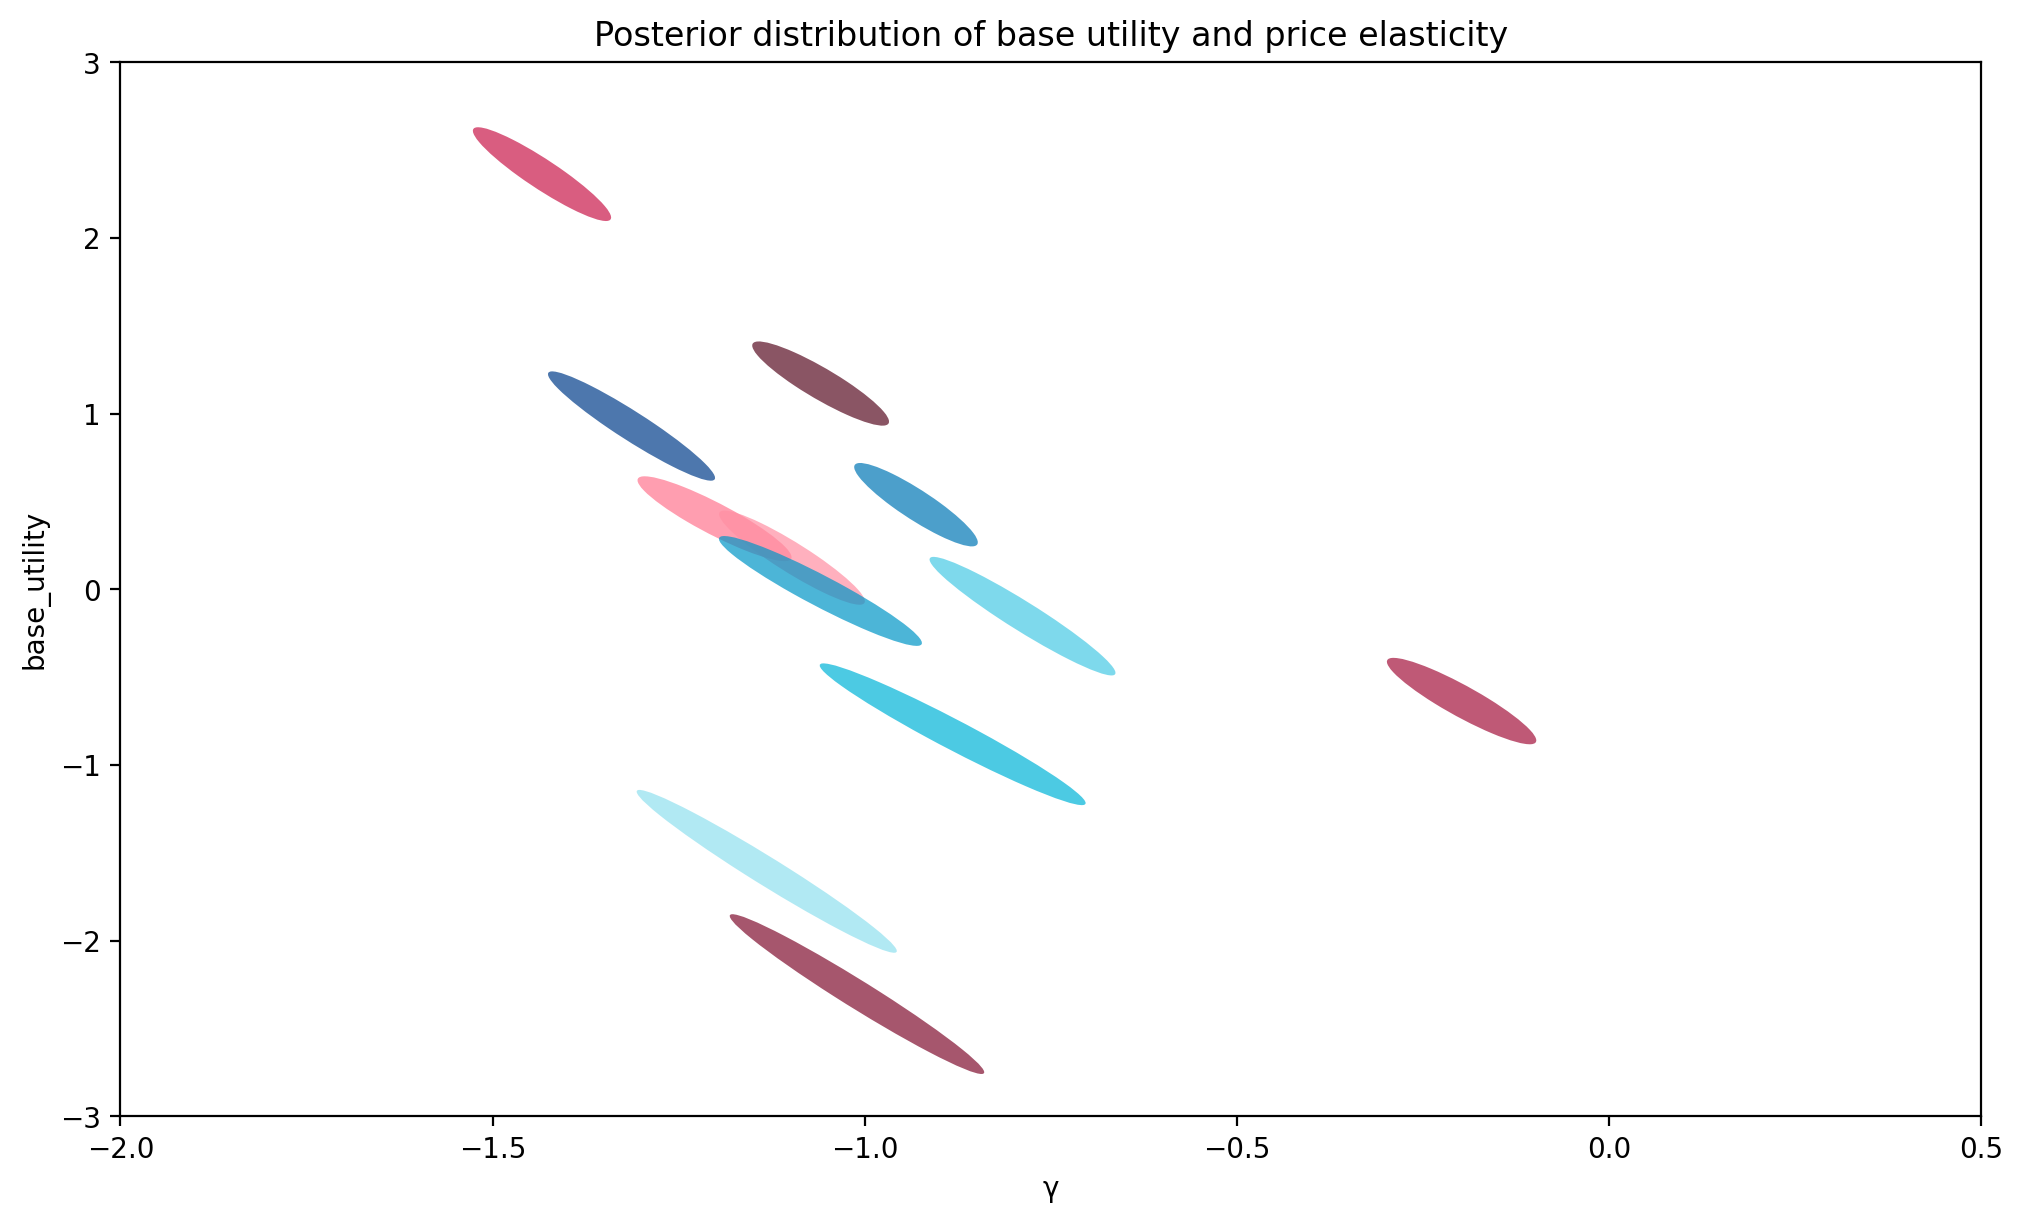

In [73]:
def plot_cov_ellipse(mean, cov, ax, n_std=1.0, **kwargs):
    """
    Plots an ellipse representing a bivariate normal distribution.

    mean: (x, y) coordinates of the center of the ellipse.
    cov: 2x2 covariance matrix.
    ax: Axis to plot on.
    n_std: Number of standard deviations to determine the ellipse's radii.
    kwargs: Additional keyword arguments for Ellipse.
    """
    # Compute the eigenvalues and eigenvectors
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Compute angle
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height of the ellipse
    width, height = 2 * n_std * np.sqrt(vals)

    # Create and add ellipse patch to the axis
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)


# Plotting
fig, ax = plt.subplots()

# cols = [f"C{i}" for i in range(n_items)]

posterior = az.extract(idata_simple_logit_model)

# Loop through each item
for i, brand in enumerate(idata_simple_logit_model.constant_data.brand.values):
    # Extract samples for γ and base_utility
    γ_samples = (
        posterior["γ"].sel({"brand": brand}).values
    )
    base_utility_samples = (
        posterior["base_utility"]
        .sel({"brand": brand})
        .values
    )

    # Compute mean and covariance matrix for γ and base_utility
    mean = [np.mean(γ_samples), np.mean(base_utility_samples)]
    cov = np.cov(γ_samples, base_utility_samples)
    # print(mean, cov)

    # Plot the bivariate normal ellipse
    plot_cov_ellipse(
        mean, cov, ax, n_std=1, edgecolor="none", facecolor=colors[i], alpha=0.7
    )

    # Annotate the true values
    # ax.annotate(txt, (γ_true[i], base_utility_true[i]))

    # Plot line from true value to the mean of the ellipse
    # ax.plot(
    #     [γ_true[i], mean[0]],
    #     [base_utility_true[i], mean[1]],
    #     color=cols[i],
    #     linestyle="-",
    #     alpha=0.7,
    # )

# Plot the true values
# plt.scatter(γ_true, base_utility_true, color=cols)

# Set axis labels and title
ax.set(
    xlabel="γ",
    ylabel="base_utility",
    title="Posterior distribution of base utility and price elasticity",
    xlim=[-2, .5],
    ylim=[-3, 3],
);

This plot shows the posterior distribution of both the price elasticity and the baseline utility, summarised in the form of ellipses which show the 1 standard deviation region.

We can see that there is some variety across items in terms of price elasticity and base utility.

### Exploring counterfactual scenarios

In this section, we're going to do some badass causal stuff. We're going to look at one of the products that was introduced and estimate the causal impact it had upon the sales of other products.

In [164]:
acv_counterfactual[-1]

array([0.        , 0.97967459, 0.        , 0.        , 0.81441205,
       0.91988219, 0.94192694, 0.90595345, 0.        , 0.96437067,
       0.        , 0.92437501])

In [151]:
# kill the last product. Assures that it's one that was newly introduced during the time
# period.
brand_to_kill_idx = 3
brand_to_kill = product_df.iloc[brand_to_kill_idx]
brand_to_kill

manufacturer    Precter & Jangle
segment                    Adult
brand           Cwest Gum Detoxo
Name: 3, dtype: object

In [185]:
# create counterfactual ACV data
acv_counterfactual = np.copy(acv)
acv_counterfactual[:, brand_to_kill_idx] = 0.0

# do posterior prediction under that counterfactual ACV scenario
with simple_logit_model:
    pm.set_data({"acv": acv_counterfactual})
    predictions = pm.sample_posterior_predictive(
        idata_simple_logit_model,
        var_names=["sales_units", "market_share"],
        predictions=True,
        random_seed=rng,
    ).predictions

Sampling: [sales_units]


Output()

In [187]:
causal_impact = (
    idata_simple_logit_model.posterior_predictive["sales_units"] 
    - predictions["sales_units"]
)

In [188]:
# remove product_to_kill_name from the list of items
remaining_brands = [brand for brand in product_df["brand"].values if brand != brand_to_kill["brand"]]
remaining_brands

['Parobontax',
 'Sensofyne Quick Relief',
 'Cwest Pro-Heels',
 'Smolgate Optic Wite',
 'Smolgate Sensotouch',
 'White Star',
 'Ninions',
 'Cwest HyperMan',
 'Cwest Happy baby',
 'Smolgate Total',
 'Smolgate Baby Wish']

In [189]:
# select just items in remaining_items from causal_impact
causal_impact = causal_impact.sel(brand=remaining_brands)

In [190]:
# find the index of the first date where acvs[:, product_to_kill] is > 0
first_non_zero = np.argmax(acv[:, brand_to_kill_idx] > 0)

# select just the values of causal_impact where date >= first_non_zero
causal_impact = causal_impact.sel(date=slice(date[first_non_zero], None))
x = range(first_non_zero, acv.shape[0])

In [191]:
# calculate the cumulative sum of the causal impact
cumulative_impact = causal_impact.cumsum(dim="date")

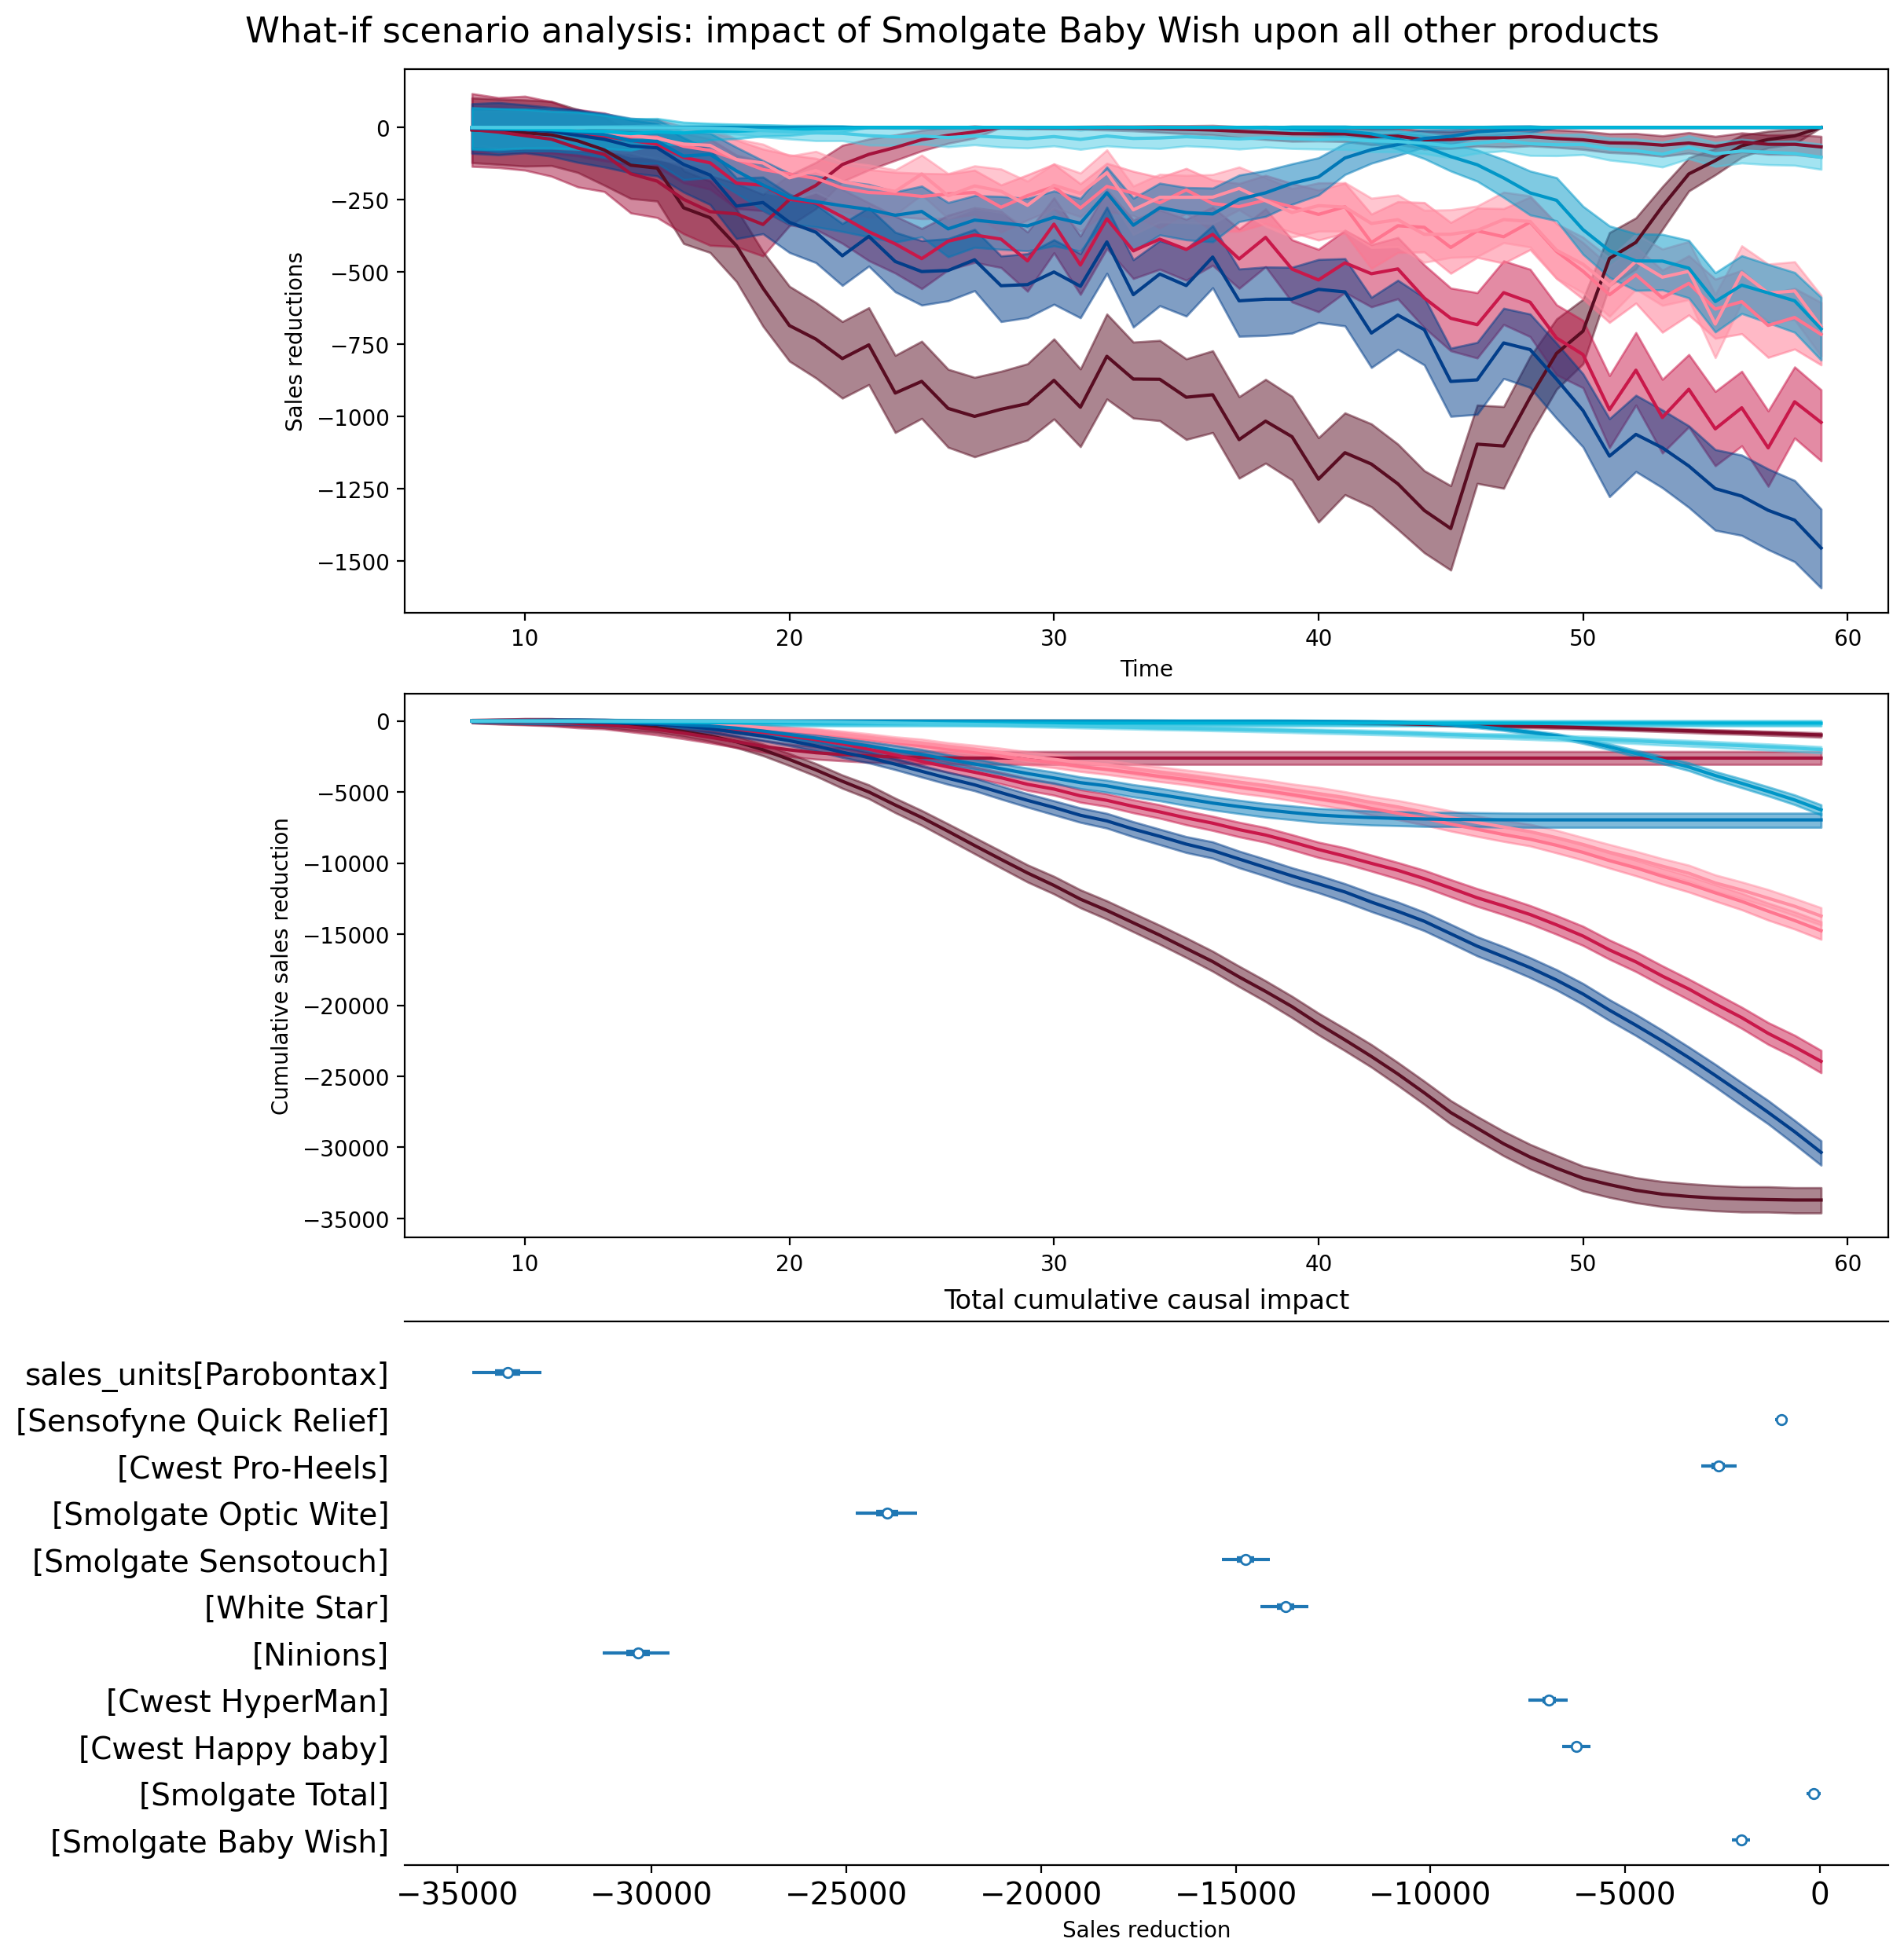

In [196]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

# Causal impact
for i, brand in enumerate(remaining_brands):
    az.plot_hdi(
        x, causal_impact.sel({"brand": brand}), color=colors[i], smooth=False, ax=ax[0]
    )
    ax[0].plot(
        x, causal_impact.sel({"brand": brand}).mean(dim=["chain", "draw"]), color=colors[i]
    )

ax[
    0
].set(  # title=f"Causal impact of removing product {product_to_kill_name} upon all other products",
    xlabel="Time", ylabel=f"Sales reductions"
)
# Cumulative causal impact
for i, brand in enumerate(remaining_brands):
    az.plot_hdi(
        x, cumulative_impact.sel({"brand": brand}), color=colors[i], smooth=False, ax=ax[1]
    )
    ax[1].plot(
        x,
        cumulative_impact.sel({"brand": brand}).mean(dim=["chain", "draw"]),
        color=colors[i],
    )

ax[1].set(ylabel="Cumulative sales reduction")
# Total cumulative impact
total_cumulative_impact = cumulative_impact.sel(date=date[-1])
az.plot_forest(total_cumulative_impact, combined=True, ax=ax[2])
ax[2].set(title=f"Total cumulative causal impact", xlabel="Sales reduction")

plt.suptitle(
    f"What-if scenario analysis: impact of {product_to_kill_name} upon all other products",
    y=1.025,
    fontsize=16,
);

### Limitations of the basic discrete choice model

So this is looking pretty cool. We've got a setup where:
* We have a model that links distribution (ACV) and price data to sales volumes.
* It estimates base utilities and price elasticities for each product.
* It can be used to estimate the causal impact of new product introductions.
* We can estimate the causal impact on own vs other manufacturer products - as in estimate the level of cannibalization and innovation, respectively.

So what's the catch?

**The catch is that this model is incapable of generating "interesting" patterns of cannibalisation.** What we mean by this is that in our counterfactual scenario where we consider a product introduction never happened, the model will predict that the market share of the remaining products increase proportionally.

We can demonstrate this by plotting the posterior relative change in market_share at a specific date, and nothing it is the same for all items:

In [222]:
change = causal_impact.isel(date=-1).mean(("chain", "draw"))
change /= 

<xarray.DataArray 'sales_units' (brand: 11)> Size: 88B
array([    0.     ,   -67.479  ,     0.     , -1020.82725,  -716.2165 ,
        -689.18725, -1455.5265 ,     0.     ,  -697.52975,     0.     ,
        -103.4305 ])
Coordinates:
    date     datetime64[ns] 8B 2024-05-10
  * brand    (brand) <U22 968B 'Parobontax' ... 'Smolgate Baby Wish'

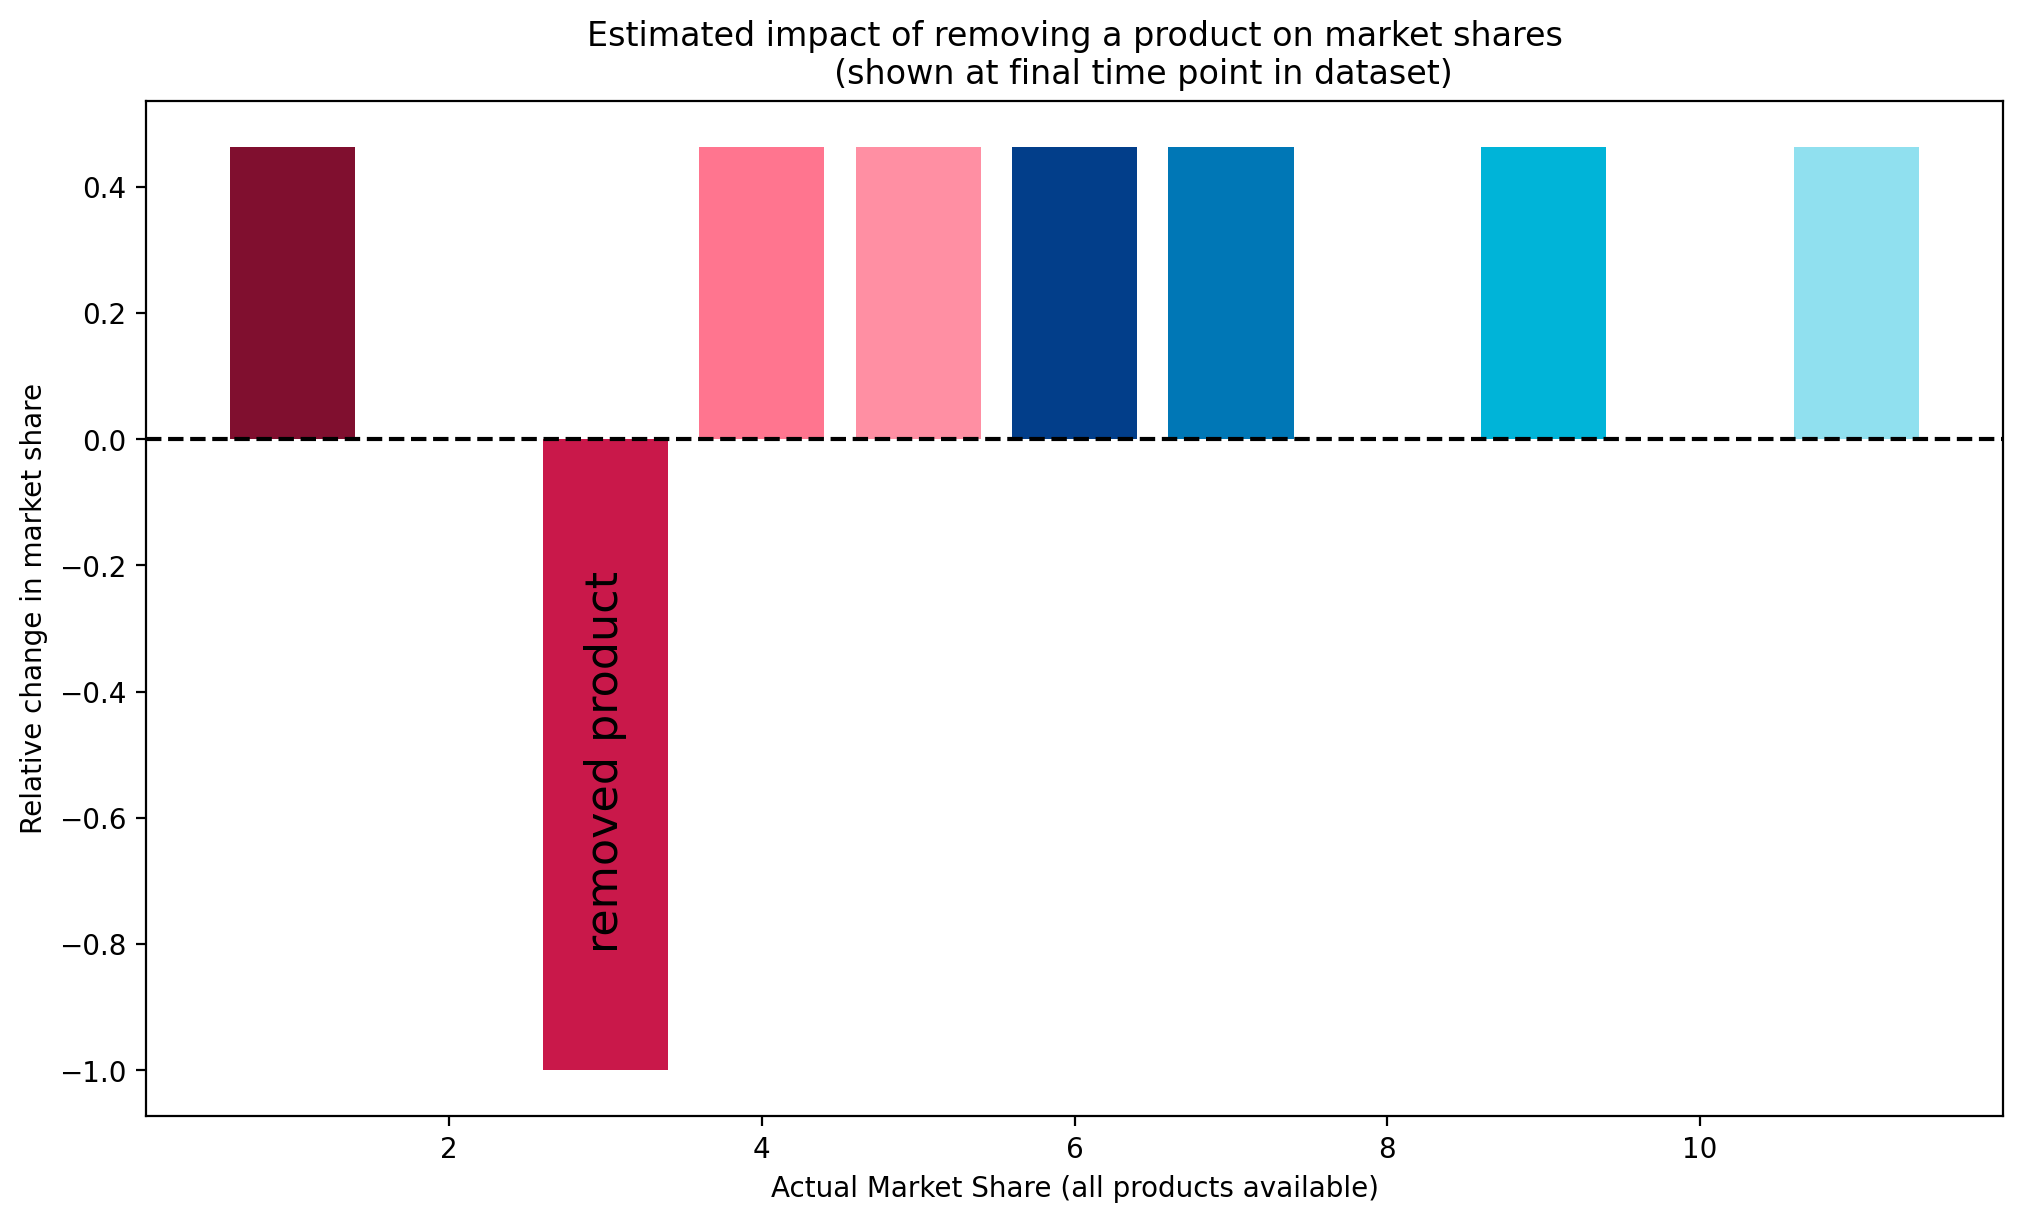

In [260]:
fig, ax = plt.subplots()

final_market_share_actual = idata_simple_logit_model.posterior["market_share"].isel(date=-1).mean(("chain", "draw"))
final_market_share_counterfactual = predictions["market_share"].isel(date=-1).mean(("chain", "draw"))

x = range(12)
plt.bar(
    x,
    (final_market_share_counterfactual - final_market_share_actual) / final_market_share_actual,
    color=colors
)

# # Calculate means and error bars
# x_means = final_market_share_actual.mean(dim=["chain", "draw"])
# y_means = final_market_share_counterfactual.mean(dim=["chain", "draw"])
# x_err = final_market_share_actual.std(dim=["chain", "draw"])
# y_err = final_market_share_counterfactual.std(dim=["chain", "draw"])

# # Plot means with error bars
# ax.errorbar(x_means, y_means, xerr=x_err, yerr=y_err, fmt="o", ecolor="C0", capsize=5)
ax.set_xlabel("Actual Market Share (all products available)")
ax.set_ylabel("Relative change in market share")
ax.set_title("""Estimated impact of removing a product on market shares
             (shown at final time point in dataset)""")


# Add text label for the removed product
ax.text(
    brand_to_kill_idx,
    -0.8,    
    "removed product",
    rotation=90,
    ha="center",
    fontsize=16
)

ax.axhline(0, color="k", ls="--");

This is almost certainly _not_ what we would expect to see in the real world. 

For example, if the newly introduced product was marketed in the "kids" segment, we might expect that that product to take sales from other products in that category, but not (as much) from other categories such as "adult" segment. This is a more complex pattern of cannibalization than the model is capable of capturing.

So despite the fact that this model has a lot of strengths given its relative simplicity, this limitation in how accurately it can model cannibalization patterns is a significant drawback. It is this which pushed us to develop a more advanced model for our client.

## What's missing

What our intution is telling us in a mathematical sense is that that some factor not present in our model must be driving people's choices. For example, the number of kids in the household, which would translate into a need (preference) for "kid-friendly" toothpaste items. If a kid item is removed from distribution, a large portion of the customers that were buying this item will likely want to switch to another item that is similarly "kid-friendly".

Clearly, in our aggregated dataset of total sales, we can't access this kind of details about individual customers. But knowing what's wrong gives us a hint of how to push ahead. It is the error terms in the simple discrete choice model that compensates for the lack of perfect knowledge about drives choices. By defining them as Independent and Identically distributed (Logistic in our case), we condemned the model to not expect any correlation among these unobserved factors across different items. If unobserved factors are uncorrelated, so will be replacement choices!

So we must allow the model to look for correlations in unobserved factors. There is an infinite number of choices we could take. Fortunately we don't have to start from scratch. Research in economics and the utility maximization framework that we alluded to, has highlighted a couple of models that are generally applicable and still computationally feasible. In our collaboration with Colgate-Palmolive we developed on two such models, the first of which we describe here: the Nested Logit model.

## Nested Logit discrete choice model

The nested logit model is, in essence, a series of simple logit models glued together hierarchically, in a way that still respects the idea of utility maximation. 

Items are grouped into distinct nests, like as "segment" and "brand", that we whope will capture these unobserved factors. Ideally, items within the same nest will all share all the important latent factors we cannot measure, whereas items across different nests will not. This means errors should be correlated within nests and, subsequently, preferrential substitution patterns should be observed within them as well.

Furthermore, nests can be ordered hierarchically. We may believe items of the same brand within the same segment share more of these characteristics that drive choices, than items of the same brand across different segments. This would mean, we believe in a "segment -> brand" hierarchy. As we go down the hierarchy, substitution patterns will increase in strength.

:show a tree diagram:

Alternatively, if brand is a much stronger driver of choice than segment, we would define a "brand -> segment" model, where we believe cannibalization will be much stronger across segments of the same brand, than across brands of the same segment. 

:show the other tree diagram:

The nested logit model allows us to study this sort of nuance!

### The math

...

Mention it breaks choice as a series of conditional probabilities...

### An example of the kind of output we get

For brevity we will not show the nitty-gritty implemtation of the model. To make up for it we will be releasing the source-code in the near future! For now you can take our word from it, that it works. This is how it looks from the outside:

In [47]:
coords = dict(
    item=product_df["Brand"].to_list(),
    segment=product_df["Segment"].unique(),
    manufacturer=product_df["Manufacturer"].unique(),
    date=date,
)

with pm.Model(coords=coords) as nested_logit_model:
    # Data
    acv_data = pm.Data("acv", acv, dims=["date", "item"])
    total_sales_data = pm.Data("total_sales", total_sales, dims=["date"])
    # price = pm.Data("price", price_data, dims=["date", "item"])
    log_price_data = pm.Data("log_price", np.log(price_data), dims=["date", "item"])

    # Priors
    γ = pm.Normal("γ", mu=-0.8, sigma=0.2, dims="item")
    base_utility = pm.Normal("base_utility", dims="item")

    # Model
    # Rather than computing: (base_utility + np.log(acv)) * price**γ
    # We compute: base_utility + np.log(acv) + γ * log(price)
    # This offers improved numerical stability and keeps the model 'linear in the parameters'
    utility = pm.Deterministic(
        "utility",
        base_utility + pm.math.log(acv_data) + γ * log_price_data,
        dims=["date", "item"],
    )

    hierarchy = pd.MultiIndex.from_frame(product_df)
    segment_importance = pm.Uniform("segment_importance", dims="segment")
    brand_importance = pm.Uniform("brand_importance", lower=segment_importance, dims=["brand", "segment"])
    log_probability = nested_log_probability(utility, hierarchy, [segment_importance, brand_importance])
    
    market_share = pm.Deterministic(
        "market_share", pm.math.exp(log_probability), dims=["date", "item"]
    )

    # Likelihood
    pm.Multinomial("sales_units", n=total_sales_data, p=market_share, dims=["date", "item"])

TypeError: Shared variable values can not be symbolic.

This looks almost like the original model with these lines changed:

```python
hierarchy = pd.MultiIndex.from_frame(product_df)
segment_importance = pm.Uniform("segment_importance", dims="segment")
brand_importance = pm.Uniform("brand_importance", lower=segment_importance, dims=["brand", "segment"])
log_probability = nested_log_probability(utility, hierarchy, [segment_importance, brand_importance])

market_share = pm.Deterministic("market_share", pm.math.exp(log_probability), dims=["date", "item"])
```

The `market_share` is no longer a simple softmax, but a more complicated function of the items utility and the segment and brand importances, as well as their hierarchical structure. The function `nested_log_probability` implements the mathematics of the nested logit model in an efficient and scallable manner. It returns the log-probability of the different item choices that we exponentiate to arrive at the expected market share.

... Show some sampling results

## Summary

**TODO: Ben to write this (probably)**